In [ ]:
# !pip install causalis

# Uncofoundedness

We call 'Uncofoundedness' a scenario where a treatment is not randomly assigned to participants, so confounders effect on treatment assignment and outcome.

Treatment - purchase in one category.

We will test hypothesis:

$H_o$ - There is no difference in LTV between treatment and control groups.

$H_a$ - There is a difference in LTV between treatment and control groups.

In [1]:
from causalis.scenarios.unconfoundedness.dgp import generate_obs_hte_26_rich

data = generate_obs_hte_26_rich(return_causal_data=False, include_oracle=True)
data.head()


,y,d,tenure_months,avg_sessions_week,spend_last_month,age_years,income_monthly,prior_purchases_12m,support_tickets_90d,premium_user,mobile_user,urban_resident,referred_user,m,m_obs,tau_link,g0,g1,cate
0,0.000000,0.0,28.814654,1.0,77.936767,50.234101,1926.698301,1.0,2.0,1.0,1.0,1.0,0.0,0.047970,0.047970,1.330764,8.137981,35.177086,27.039105
1,559.364158,1.0,25.913345,3.0,53.777740,28.115859,5104.271509,3.0,0.0,1.0,1.0,0.0,1.0,0.049695,0.049695,2.190209,60.459257,584.580685,524.121427
2,26.143003,1.0,24.969929,10.0,134.764322,22.907062,5267.938255,8.0,3.0,0.0,1.0,1.0,0.0,0.077087,0.077087,1.570177,7.712855,38.297992,30.585137
3,19.283585,1.0,40.655089,5.0,59.517074,31.970490,6597.327018,3.0,2.0,1.0,1.0,1.0,0.0,0.069481,0.069481,1.933844,25.386510,189.737828,164.351318
4,0.000000,1.0,18.560899,3.0,74.370930,39.237248,4930.009628,5.0,1.0,1.0,1.0,0.0,0.0,0.047097,0.047097,1.818265,15.359250,102.433597,87.074347


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")

Ground truth ATE is 617.0712367740982
Ground truth ATTE is 837.4043605736649


In [3]:
from causalis.data_contracts import CausalData

causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'age_years', 'income_monthly', 'prior_purchases_12m', 'support_tickets_90d', 'premium_user', 'mobile_user', 'urban_resident', 'referred_user'])
causaldata

CausalData(df=(100000, 13), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'age_years', 'income_monthly', 'prior_purchases_12m', 'support_tickets_90d', 'premium_user', 'mobile_user', 'urban_resident', 'referred_user'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,95015,73.966492,238.503707,0.0,0.0,0.0,7.448482,62.190137,184.701873,21396.007575
1,1.0,4985,907.471726,2545.077996,0.0,0.0,0.0,143.706288,730.651759,2269.458998,48466.747037


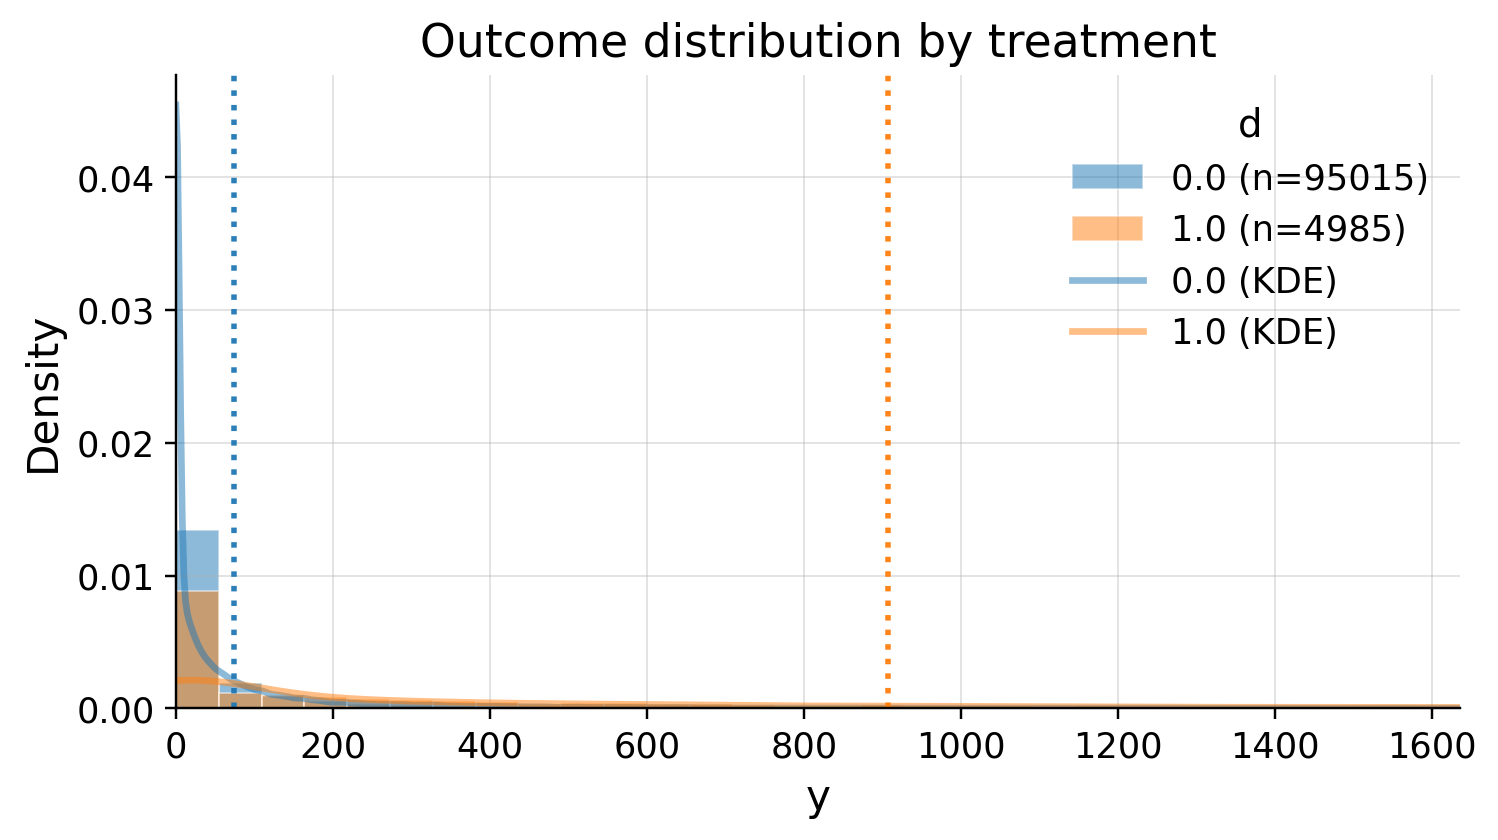

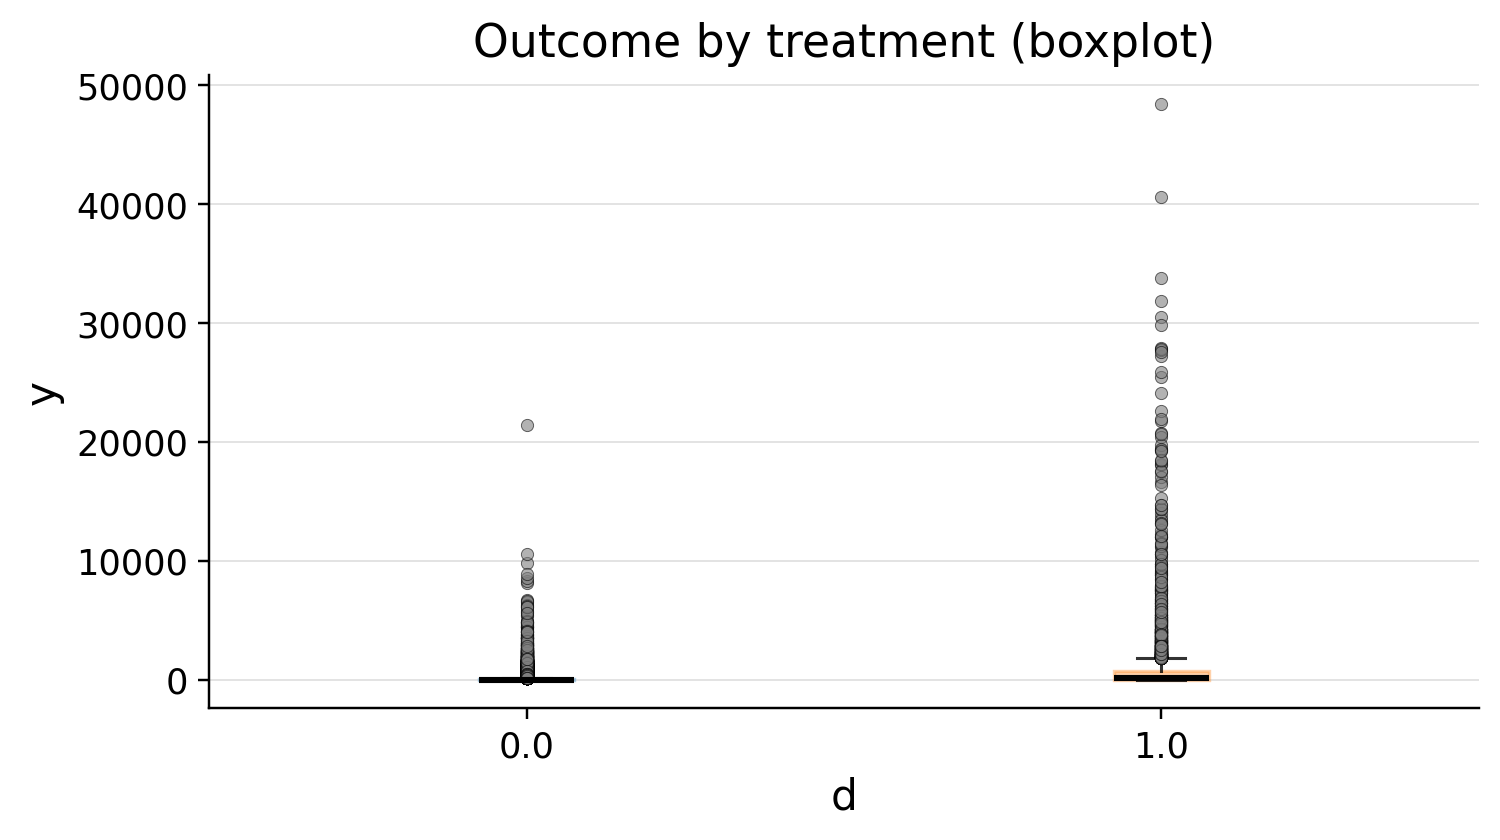

(<Figure size 1540x880 with 1 Axes>, <Figure size 1540x880 with 1 Axes>)

In [5]:
from causalis.shared import outcome_plots
outcome_plots(causaldata)

In [6]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,spend_last_month,86.467107,117.559365,31.092259,0.329735,0.00000
1,avg_sessions_week,4.945293,6.188967,1.243674,0.287878,0.00000
2,premium_user,0.738199,0.852357,0.114158,0.285782,0.00000
3,prior_purchases_12m,3.863548,4.291675,0.428127,0.200809,0.00000
4,income_monthly,4496.964003,4921.775317,424.811314,0.169596,0.00000
5,age_years,36.446101,34.628006,1.818095,-0.162591,0.00000
6,referred_user,0.270599,0.323771,0.053172,0.116536,0.00000
7,mobile_user,0.872546,0.908726,0.036180,0.116115,0.00001
8,urban_resident,0.597169,0.638114,0.040945,0.084327,0.00000
9,support_tickets_90d,0.994138,1.074423,0.080286,0.077965,0.00002


# Inference

In [7]:
from causalis.scenarios.unconfoundedness import IRM

model = IRM().fit(causaldata)

### Math Explanation of the IRM Model and ATTE Estimand

The **Interactive Regression Model (IRM)** is a flexible framework used in Double Machine Learning (DML) to estimate treatment effects. Unlike linear models, it allows the treatment effect to vary with confounders $X$ (interaction) and makes no parametric assumptions about the functional forms of the outcomes.

We write $W=(Y,D,X)$ for an observation, where $D\in\{0,1\}$ is treatment and $Y$ is the observed outcome.



#### 1. Nuisance Functions
The IRM framework relies on three "nuisance" components estimated from the data:
*   **Outcome Regression (Control):** $g_0(X) = \mathbb{E}[Y | X, D=0]$
*   **Outcome Regression (Treated):** $g_1(X) = \mathbb{E}[Y | X, D=1]$
*   **Propensity Score:** $m(X) = \mathbb{P}(D=1 | X)$

Let $p = \mathbb{P}(D=1) = \mathbb{E}[D]$ denote the overall treatment rate (estimated by the sample mean of $D$).

In the provided implementation (`irm.py`), these are estimated using cross-fitting (splitting data into folds) to avoid overfitting bias.



#### 2. ATTE (Average Treatment Effect on the Treated)
The **Average Treatment Effect on the Treated (ATTE)** measures the impact of the treatment specifically on those individuals who received it:
$$\theta_{ATTE} = \mathbb{E}[Y(1) - Y(0) \mid D=1]$$

Under **unconfoundedness**, $(Y(1),Y(0)) \perp D \mid X$, and overlap $0 < m(X) < 1$, this is identified from observed data.



#### 3. The Orthogonal Score
DML uses a **Neyman-orthogonal score** $\psi$ to ensure the estimator is robust to small errors in the nuisance function estimates. The score for ATTE is defined as:
$$\psi(W; \theta, \eta) = \psi_b(W; \eta) + \psi_a(W; \eta)\theta$$

To match the implementation in `irm.py`, define:
*   **Residuals:** $u_0 = Y - g_0(X)$, $u_1 = Y - g_1(X)$
*   **IPW terms:** $h_1 = \frac{D}{m(X)}$, $h_0 = \frac{1-D}{1-m(X)}$
*   **Weights (ATTE):** $w = \frac{D}{p}$ and $\bar{w} = \frac{m(X)}{p}$ (the normalized form with $\mathbb{E}[w]=1$)

Then:
\begin{aligned}
\psi_a(W;\eta) &= -w = -\frac{D}{p} \\
\psi_b(W;\eta) &= w\,(g_1(X)-g_0(X)) + \bar{w}\,(u_1 h_1 - u_0 h_0)
\end{aligned}

(If `normalize_ipw=True`, the code rescales $h_1$ and $h_0$ to have mean 1.)



#### 4. Final Estimation (Step-by-step simplification)
For brevity, write $m = m(X)$, $g_0 = g_0(X)$, and $g_1 = g_1(X)$. Plug in $w, \bar{w}, h_1, h_0$:

\begin{aligned}
\psi_b
&= \frac{D}{p}(g_1-g_0)
  + \frac{m}{p}\left[\frac{D}{m}(Y-g_1) - \frac{1-D}{1-m}(Y-g_0)\right] \\
&= \frac{D}{p}(g_1-g_0) + \frac{D}{p}(Y-g_1) - \frac{m}{p}\frac{1-D}{1-m}(Y-g_0) \\
&= \frac{D}{p}(Y-g_0) - \frac{m}{p}\frac{1-D}{1-m}(Y-g_0).
\end{aligned}

So the $g_1(X)$ terms cancel, and the ATTE score depends only on $g_0(X)$ and $m(X)$.

The estimator solves $\mathbb{E}[\psi(W;\theta,\eta)]=0$:
\begin{aligned}
\hat{\theta}_{ATTE}
&= \frac{\mathbb{E}[\psi_b]}{\mathbb{E}[-\psi_a]}
= \frac{\mathbb{E}[\psi_b]}{\mathbb{E}[D/p]}
= \mathbb{E}[\psi_b].
\end{aligned}

Equivalently,
$$\hat{\theta}_{ATTE} = \mathbb{E}\left[\frac{D}{p}(Y-g_0(X)) - \frac{m(X)}{p}\frac{1-D}{1-m(X)}(Y-g_0(X))\right].$$



In [8]:
result = model.estimate(score='ATTE')
result.summary()

,estimand,coefficient,p_val,lower_ci,upper_ci,relative_diff_%,is_significant
0,ATTE,816.966741,0.0,749.154822,884.77866,893.17824,True


In [9]:
result

CausalEstimate(estimand='ATTE', model='IRM', model_options={'n_folds': 5, 'n_rep': 1, 'normalize_ipw': False, 'trimming_rule': 'truncate', 'trimming_threshold': 0.01, 'random_state': None, 'std_error': 34.59855341330873, 't_stat': 23.61274273910593}, value=816.9667408936743, ci_upper_absolute=884.7786595009447, ci_lower_absolute=749.1548222864039, value_relative=893.1782401420442, ci_upper_relative=967.3160563964027, ci_lower_relative=819.0404238876857, alpha=0.05, p_value=0.0, is_significant=True, n_treated=4985, n_control=95015, outcome='y', treatment='d', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'age_years', 'income_monthly', 'prior_purchases_12m', 'support_tickets_90d', 'premium_user', 'mobile_user', 'urban_resident', 'referred_user'], time=datetime.datetime(2026, 1, 27, 8, 26, 46, 441822), diagnostic_data=UnconfoundednessDiagnosticData(m_hat=array([0.05620082, 0.06597108, 0.12947216, ..., 0.03993944, 0.06856774,
       0.0686461 ], shape=(100000,)), d

In [10]:
from causalis.scenarios.unconfoundedness.refutation import *
rep = run_overlap_diagnostics(res=result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.000000,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.183620,RED
3,edge_0.02_above,0.000000,RED
4,KS,0.193386,GREEN
5,AUC,0.623803,GREEN
6,ESS_treated_ratio,0.639887,GREEN
7,ESS_control_ratio,0.998503,GREEN
8,tails_w1_q99/med,5.610889,GREEN
9,tails_w0_q99/med,1.307781,GREEN


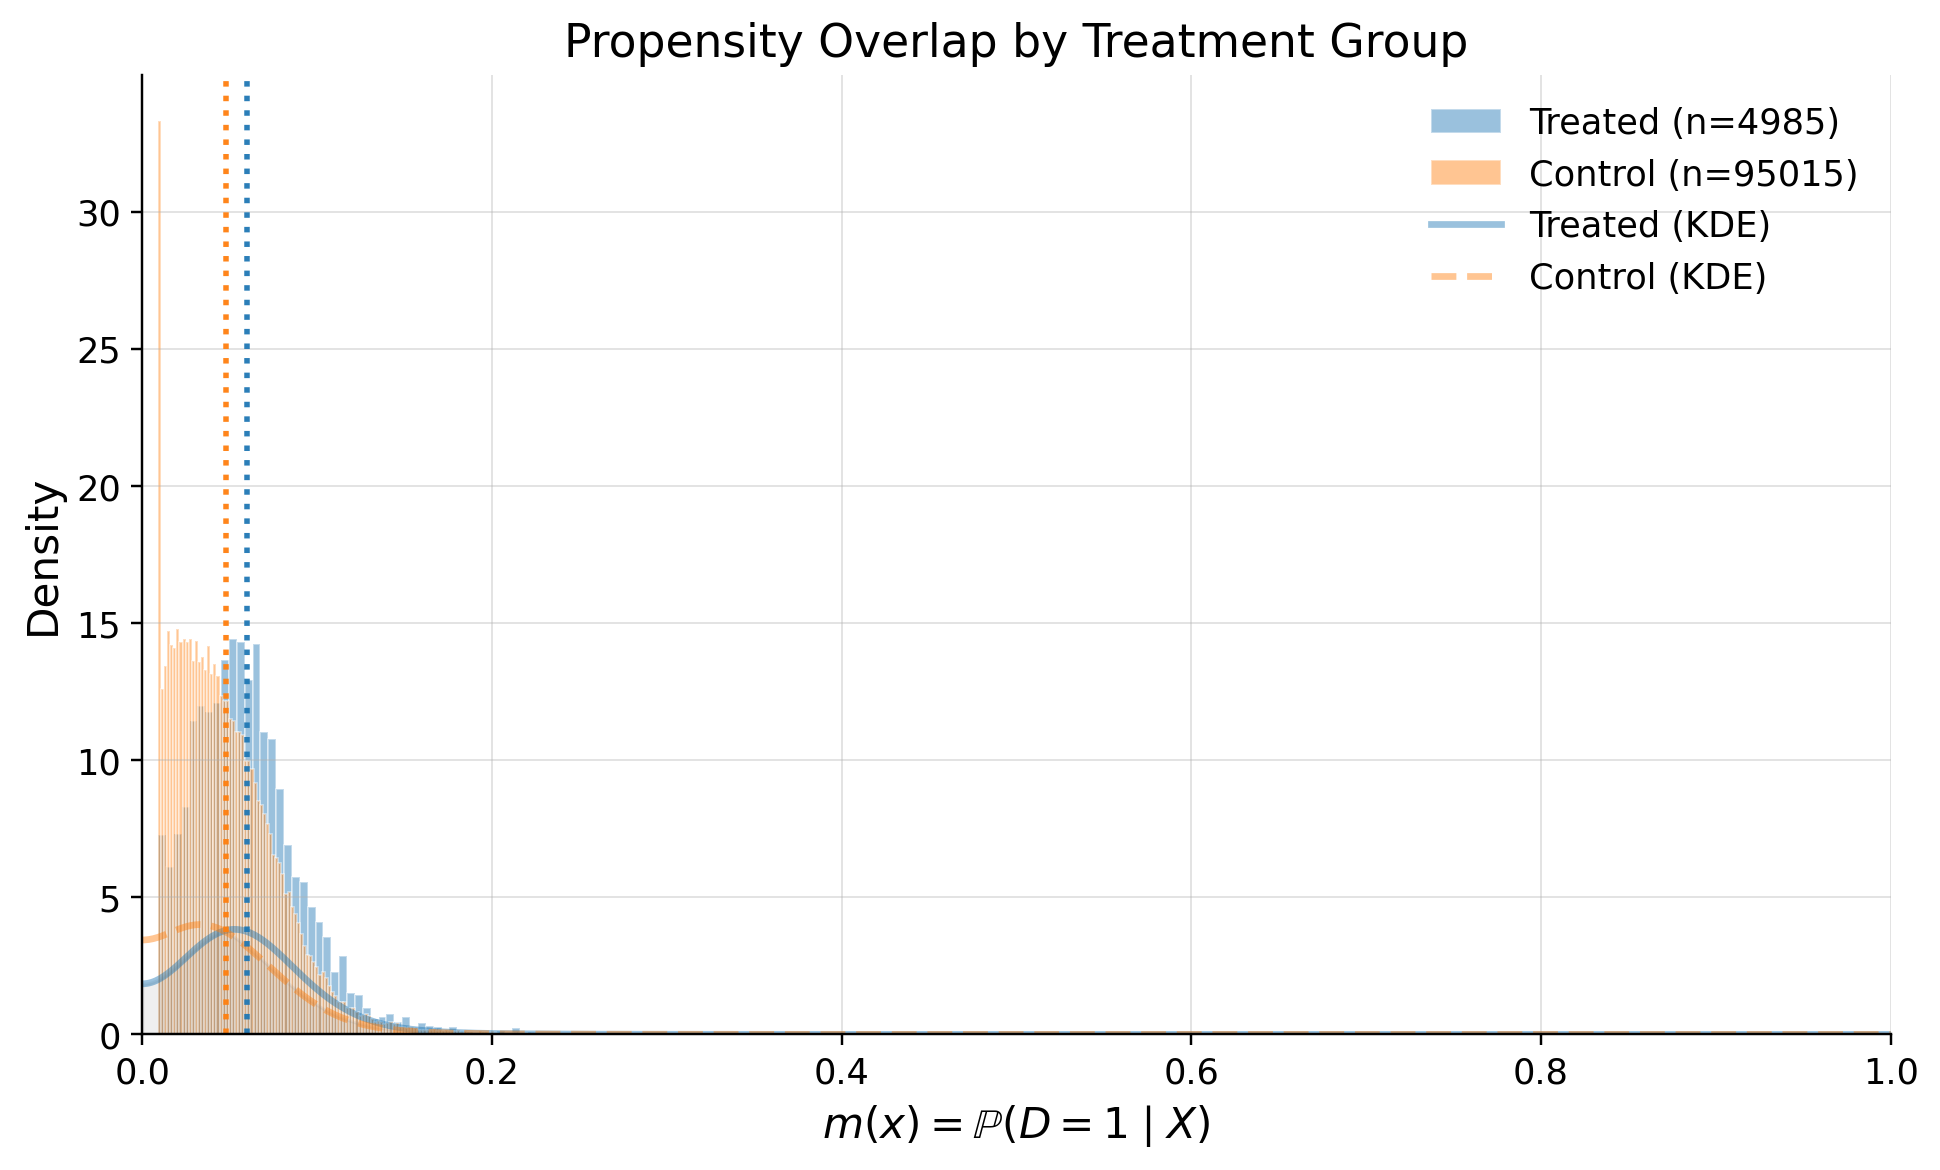

In [11]:
plot_m_overlap(result.diagnostic_data)

In [12]:
from causalis.scenarios.unconfoundedness.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(res=result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,34.598553,NA
1,psi_p99_over_med,828.340166,RED
2,psi_kurtosis,1769.053579,RED
3,max_|t|_g1,0.000000,GREEN
4,max_|t|_g0,0.872006,GREEN
5,max_|t|_m,0.417469,GREEN


In [13]:
print_sutva_questions()

1.) Are your clients independent (i)?
2.) Do you measure confounders, treatment, and outcome in the same intervals?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


In [14]:
from causalis.scenarios.unconfoundedness.refutation.uncofoundedness.uncofoundedness_validation import run_uncofoundedness_diagnostics

rep_uc = run_uncofoundedness_diagnostics(res=result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,0.018554,GREEN
1,balance_frac_violations,0.000000,GREEN


In [15]:
from causalis.scenarios.unconfoundedness.refutation.uncofoundedness.sensitivity import (
    sensitivity_analysis, sensitivity_benchmark
)

sensitivity_analysis(result, r2_y=0.01, r2_d=0.01, rho=1.0, alpha=0.05)

{'theta': 816.9667408936743,
 'se': 34.59855341330873,
 'alpha': 0.05,
 'z': 1.959963984540054,
 'H0': 0.0,
 'sampling_ci': (749.1548222864039, 884.7786595009447),
 'theta_bounds_cofounding': (794.9964525215009, 838.9370292658477),
 'bias_aware_ci': (728.8783636080927, 908.4863956227268),
 'max_bias': 21.97028837217341,
 'sigma2': 230611.39428973786,
 'nu2': 20.51450972522466,
 'rv': 0.2730480733887724,
 'rva': 0.2561902047512034,
 'params': {'r2_y': 0.01, 'r2_d': 0.01, 'rho': 1.0, 'use_signed_rr': False}}

In [16]:
sensitivity_benchmark(result.diagnostic_data, benchmarking_set =['tenure_months'])

,r2_y,r2_d,rho,theta_long,theta_short,delta
d,0.000261,0.000496,-1.0,816.966741,816.176488,0.790253
